In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

In [2]:
x = torch.linspace(-5, 5, 100)
y = F.gelu(x)

In [3]:
x_var = x.clone().requires_grad_(True)
y_var = F.gelu(x_var)
y_var.sum().backward()
dy = x_var.grad

<Figure size 640x480 with 0 Axes>

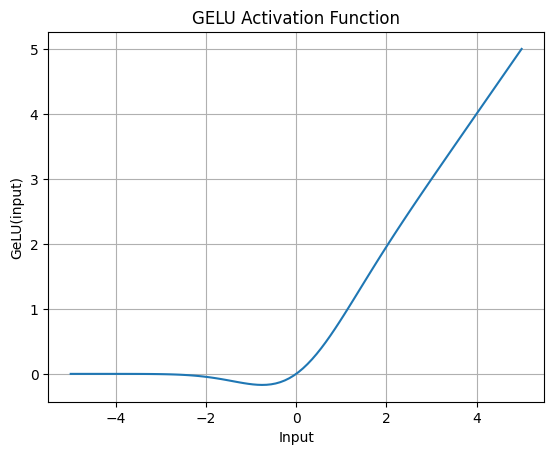

<Figure size 640x480 with 0 Axes>

In [4]:
plt.figure()
plt.plot(x, y)
plt.title('GELU Activation Function')
plt.xlabel('Input')
plt.ylabel('GeLU(input)')
plt.grid(True)
plt.figure()

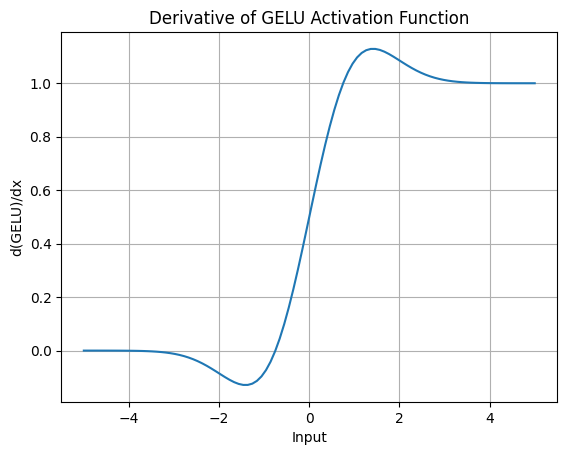

In [5]:
plt.figure()
plt.plot(x, dy)
plt.title('Derivative of GELU Activation Function')
plt.xlabel('Input')
plt.ylabel('d(GELU)/dx')
plt.grid(True)
plt.show()

In [11]:
x_relu = torch.linspace(-5, 5, 100)
y_relu = F.relu(x)
y_var_relu = F.relu(x_var)
y_var_relu.sum().backward()
dy_relu = x_var.grad

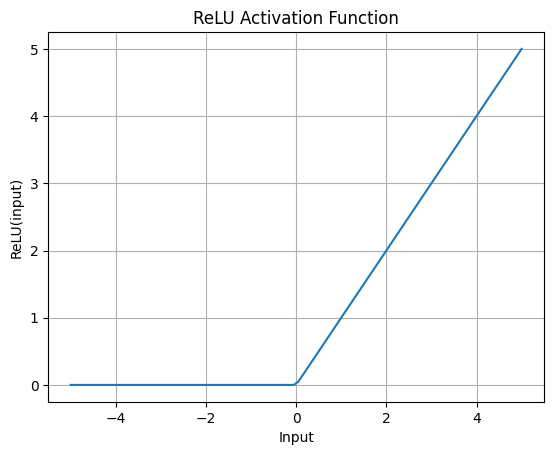

In [12]:
plt.figure()
plt.plot(x_relu, y_relu)
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('ReLU(input)')
plt.grid(True)
plt.show()

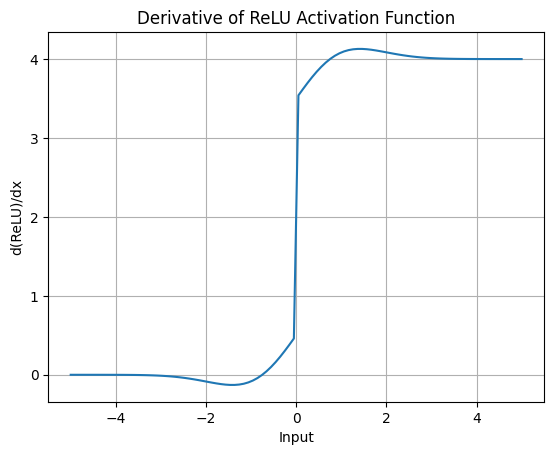

In [13]:
plt.figure()
plt.plot(x_relu, dy_relu)
plt.title('Derivative of ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('d(ReLU)/dx')
plt.grid(True)
plt.show()

In [15]:
X, Y = make_blobs(n_samples=100, centers=[(-2, -2), (2, 2)], random_state=0, cluster_std=0.60)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

In [38]:
class SimpleNN(nn.Module):
    def __init__(self, activation='relu'):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

        
        if activation == 'gelu':
            self.act = nn.GELU()
        elif activation == 'relu':
            self.act = nn.ReLU()
        else:
            raise ValueError("Unsupported activation function")
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return self.out(x)        
            

In [62]:
def train(model, X, Y, epochs=100, lr=0.1):
    opt = optim.SGD(model.parameters(), lr=lr)
    history=[]
    for epoch in range(epochs):
        model.train()
        Y_pred = model(X)
        loss = F.binary_cross_entropy(Y_pred, Y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        acc = ((Y_pred>0.5).float() == Y).float().mean().item()
        history.append((loss.item(), acc))
    return history    

In [63]:
relu_hist = train(SimpleNN(activation='relu'), X, Y)
gelu_hist = train(SimpleNN(activation='gelu'), X, Y)

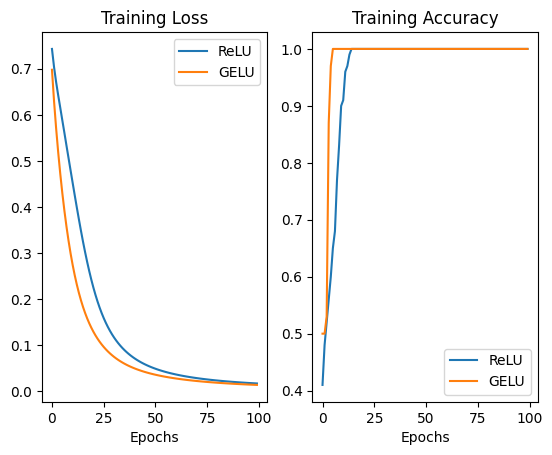

In [64]:
plt.subplot(1, 2, 1)
plt.plot([h[0] for h in relu_hist], label='ReLU')
plt.plot([h[0] for h in gelu_hist], label='GELU')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([h[1] for h in relu_hist], label='ReLU')
plt.plot([h[1] for h in gelu_hist], label='GELU')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [82]:
model_relu = SimpleNN(activation='relu')
optimizer = optim.SGD(model_relu.parameters(), lr=0.1)
criterion = nn.BCELoss()

for epoch in range(100):
    optimizer.zero_grad()
    Y_pred = model_relu(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()

print(f'Final Loss: {loss.item()}')    #theta star

Final Loss: 0.02495565265417099


In [83]:
#flatten all parameters
params = torch.cat([p.flatten() for p in model_relu.parameters()])

#two random directions of the same shape
d1= torch.randn_like(params)
d2= torch.randn_like(params) 

##Just Testing

In [84]:
apha = 1e-2
beta = 0.3
theta = params.clone() + apha * d1 + beta * d2

In [85]:
def set_weights(model, new_params):
    current_index = 0
    for p in model.parameters():
        param_length = p.numel()
        new_param = new_params[current_index:current_index + param_length].view_as(p)
        p.data = new_param
        current_index += param_length

In [86]:
set_weights(model_relu, theta)
loss = criterion(model_relu(X), Y)
print(f'Loss at theta + alpha*d1 + beta*d2: {loss.item()}')

Loss at theta + alpha*d1 + beta*d2: 0.0826200470328331


now let's create the visualization

In [87]:
alpha_vals = np.linspace(-0.1, 0.1, 50)
beta_vals = np.linspace(-0.1, 0.1, 50)
loss_surface = np.zeros((len(alpha_vals), len(beta_vals)))

criterion_BCE = nn.BCELoss()

for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        theta_ij = params + a * d1 + b * d2
        set_weights(model_relu, theta_ij)
        with torch.no_grad():
            loss_surface[i, j] = criterion_BCE(model_relu(X), Y).item()

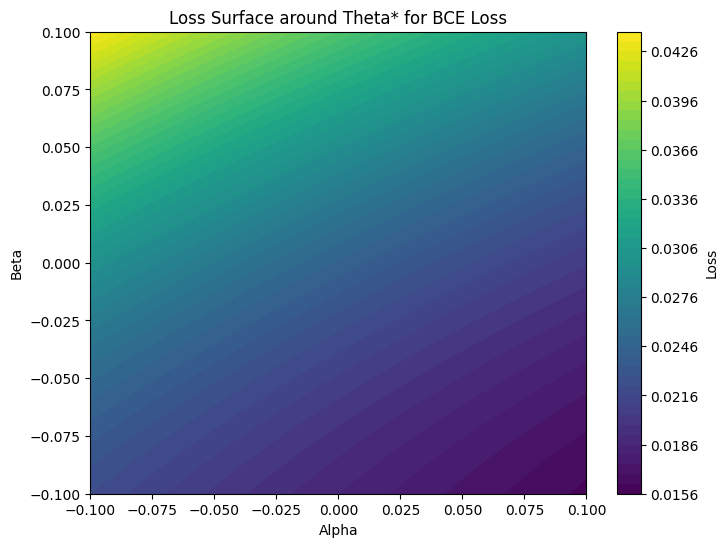

In [88]:
plt.figure(figsize=(8, 6))
plt.contourf(alpha_vals, beta_vals, loss_surface.T, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Surface around Theta* for BCE Loss')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.show()


In [89]:
criterion_MSE = nn.MSELoss()
for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        theta_ij = params + a * d1 + b * d2
        set_weights(model_relu, theta_ij)
        with torch.no_grad():
            loss_surface[i, j] = criterion_MSE(model_relu(X), Y).item()

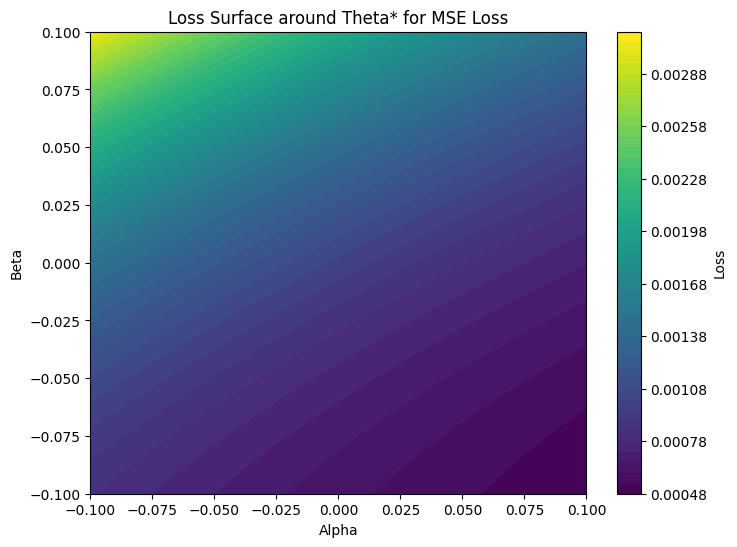

In [90]:
plt.figure(figsize=(8, 6))
plt.contourf(alpha_vals, beta_vals, loss_surface.T, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Surface around Theta* for MSE Loss')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.show()

In [92]:
model_gelu = SimpleNN(activation='gelu')
optimizer = optim.SGD(model_gelu.parameters(), lr=0.1)
criterion_gelu = nn.BCELoss()

for epoch in range(100):
    optimizer.zero_grad()
    Y_pred = model_gelu(X)
    loss_gelu = criterion_gelu(Y_pred, Y)
    loss_gelu.backward()
    optimizer.step()

print(f'Final GELU Loss: {loss_gelu.item()}')    #theta star    

Final GELU Loss: 0.11055935174226761


In [93]:
set_weights(model_gelu, theta)
loss_gelu = criterion_gelu(model_gelu(X), Y)
print(f'Loss at theta + alpha*d1 + beta*d2: {loss_gelu.item()}')

Loss at theta + alpha*d1 + beta*d2: 0.08375412225723267


In [94]:
alpha_vals = np.linspace(-0.1, 0.1, 50)
beta_vals = np.linspace(-0.1, 0.1, 50)
loss_surface_gelu = np.zeros((len(alpha_vals), len(beta_vals)))

criterion_gelu = nn.BCELoss()

for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        theta_ij = params + a * d1 + b * d2
        set_weights(model_gelu, theta_ij)
        with torch.no_grad():
            loss_surface_gelu[i, j] = criterion_gelu(model_gelu(X), Y).item()

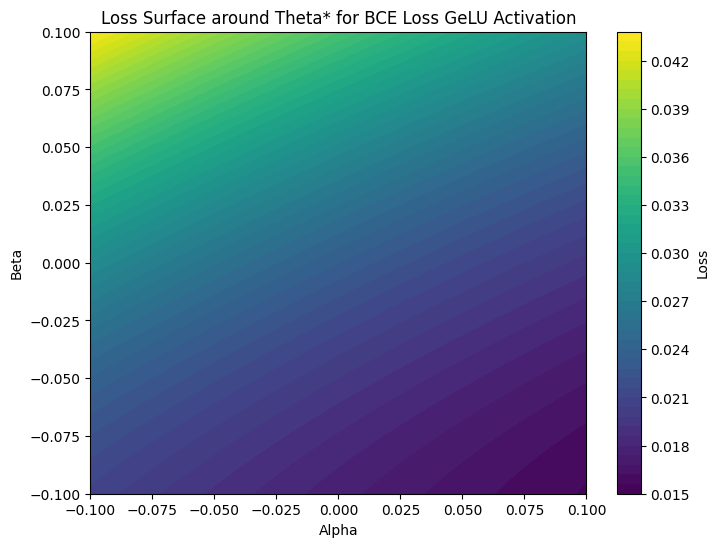

In [95]:
plt.figure(figsize=(8, 6))
plt.contourf(alpha_vals, beta_vals, loss_surface_gelu.T, levels=50, cmap='viridis')
plt.colorbar(label='Loss')
plt.title('Loss Surface around Theta* for BCE Loss GeLU Activation')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.show()